# Sidewalk

from https://raw.githubusercontent.com/sisl/AutomotiveSimulator.jl/gh-pages/dev/notebooks/sidewalk.ipynb

In this notebook, we will be creating a sidewalk environment in which
 pedestrians can walk along the sidewalk and cross the street as cars pass.

In [3]:
using Parameters
using AutomotiveSimulator
using AutomotiveVisualization
AutomotiveVisualization.colortheme["background"] = colorant"white"; # hide
using Cairo

Define sidewalk IDs

In [4]:
const TOP = 1
const BOTTOM = 2

2

### Creating the Environment
Here, we create a new type of environment called SidewalkEnv. It consists of a roadway, crosswalk, and sidewalk. A sidewalk is a Vector of Lanes that run alongside the road.

In [5]:
# create new environment
@with_kw mutable struct SidewalkEnv
    roadway::Roadway
    crosswalk::Lane
    sidewalk::Vector{Lane}
end;

#### Defining the Sidewalk
We define the sidewalk's parameters.

In [6]:
# Geometry parameters of the sidewalk
roadway_length = 100.
crosswalk_length = 15.
crosswalk_width = 6.0
crosswalk_pos = roadway_length/2
sidewalk_width = 3.0
sidewalk_pos = crosswalk_length/2 - sidewalk_width / 2

6.0

Now we create the sidewalk environment.
Our environment will consist of:
* 1-way road with 2 lanes
* Unsignalized zebra crosswalk perpendicular to the road
* Sidewalks above and below the road

Generate straight roadway of length roadway_length with 2 lanes.
Returns a Roadway type (Array of segments).
There is already a method to generate a simple straight roadway, which we use here.

In [7]:
# gernerate the roadway
roadway = gen_straight_roadway(2, roadway_length)

Roadway

Generate the crosswalk.
Our crosswalk does not have a predefined method for generation, so we define it with a LaneTag and a curve.

In [8]:
n_samples = 2 # for curve generation
crosswalk = Lane(LaneTag(2,1), gen_straight_curve(VecE2(crosswalk_pos, -crosswalk_length/2),
                                                  VecE2(crosswalk_pos, crosswalk_length/2),
                                                   n_samples), width = crosswalk_width)
cw_segment = RoadSegment(2, [crosswalk])
push!(roadway.segments, cw_segment) # Append the crosswalk to the roadway

# Generate the sidewalk
top_sidewalk = Lane(LaneTag(3, TOP), gen_straight_curve(VecE2(0., sidewalk_pos),
                                                      VecE2(roadway_length, sidewalk_pos),
                                                        n_samples), width = sidewalk_width)
bottom_sidewalk = Lane(LaneTag(3, BOTTOM), gen_straight_curve(VecE2(0., -(sidewalk_pos - sidewalk_width)),
                                                          VecE2(roadway_length, -(sidewalk_pos - sidewalk_width)),
                                                            n_samples), width = sidewalk_width)

Lane{Float64}(LaneTag(3, 2), CurvePt{Float64}[CurvePt({0.000, -3.000, 0.000}, 0.000, 0.000, NaN), CurvePt({100.000, -3.000, 0.000}, 100.000, 0.000, NaN)], 3.0, SpeedLimit(-Inf, Inf), LaneBoundary(:unknown, :unknown), LaneBoundary(:unknown, :unknown), LaneConnection{Int64, Float64}[], LaneConnection{Int64, Float64}[])

Note: we subtract the sidewalk_width from the sidewalk position so that the edge is flush with the road.

In [9]:
sw_segment = RoadSegment(3, [top_sidewalk, bottom_sidewalk])
push!(roadway.segments, sw_segment)

3-element Vector{RoadSegment{Float64}}:
 RoadSegment{Float64}(1, Lane{Float64}[Lane{Float64}(LaneTag(1, 1), CurvePt{Float64}[CurvePt({0.000, 0.000, 0.000}, 0.000, NaN, NaN), CurvePt({100.000, 0.000, 0.000}, 100.000, NaN, NaN)], 3.0, SpeedLimit(-Inf, Inf), LaneBoundary(:broken, :white), LaneBoundary(:solid, :white), LaneConnection{Int64, Float64}[], LaneConnection{Int64, Float64}[]), Lane{Float64}(LaneTag(1, 2), CurvePt{Float64}[CurvePt({0.000, 3.000, 0.000}, 0.000, NaN, NaN), CurvePt({100.000, 3.000, 0.000}, 100.000, NaN, NaN)], 3.0, SpeedLimit(-Inf, Inf), LaneBoundary(:solid, :white), LaneBoundary(:broken, :white), LaneConnection{Int64, Float64}[], LaneConnection{Int64, Float64}[])])
 RoadSegment{Float64}(2, Lane{Float64}[Lane{Float64}(LaneTag(2, 1), CurvePt{Float64}[CurvePt({50.000, -7.500, 1.571}, 0.000, 0.000, NaN), CurvePt({50.000, 7.500, 1.571}, 15.000, 0.000, NaN)], 6.0, SpeedLimit(-Inf, Inf), LaneBoundary(:unknown, :unknown), LaneBoundary(:unknown, :unknown), LaneConnection{Int

Initialize crosswalk environment

In [10]:
env = SidewalkEnv(roadway, crosswalk, [top_sidewalk, bottom_sidewalk]);

Since there is no defined `add_renderable!` method for the crosswalk and the sidewalk, we must define it ourselves.

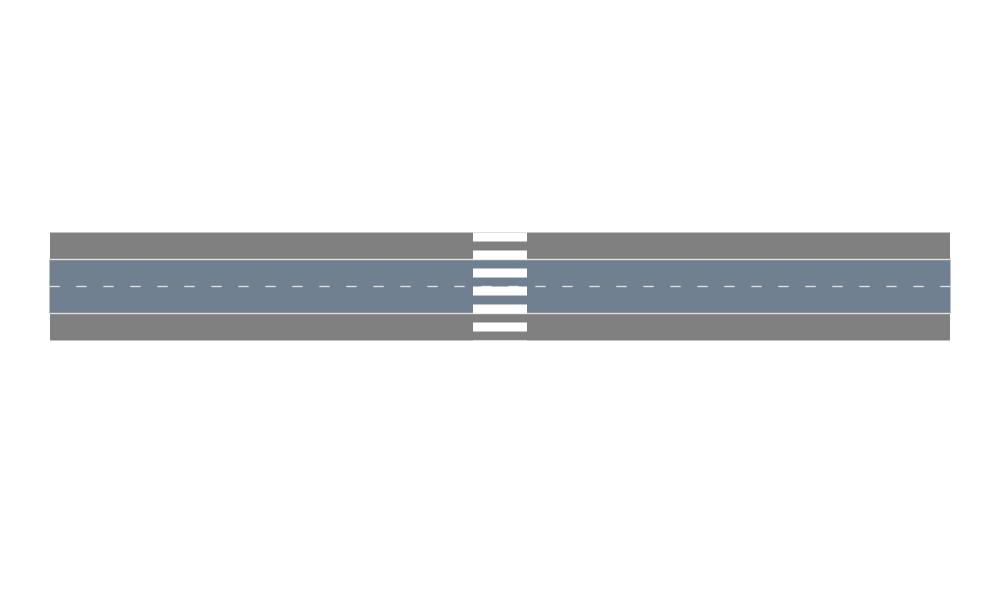

In [11]:
function AutomotiveVisualization.add_renderable!(rendermodel::RenderModel, env::SidewalkEnv)
    # Render sidewalk
    for sw in env.sidewalk
        curve = sw.curve
        n = length(curve)
        pts = Array{Float64}(undef, 2, n)
        for (i,pt) in enumerate(curve)
            pts[1,i] = pt.pos.x
            pts[2,i] = pt.pos.y
        end
        add_instruction!(rendermodel, render_line, (pts, colorant"grey", sw.width, Cairo.CAIRO_LINE_CAP_BUTT))
    end

    # Render roadway
    roadway = gen_straight_roadway(2, roadway_length)
    add_renderable!(rendermodel, roadway)

    # Render crosswalk
    curve = env.crosswalk.curve
    n = length(curve)
    pts = Array{Float64}(undef, 2, n)
    for (i,pt) in enumerate(curve)
        pts[1,i] = pt.pos.x
        pts[2,i] = pt.pos.y
    end

    # We can add render instructions from AutomotiveVisualization.
    # Here we want the crosswalk to appear as a white-striped zebra crossing rather than a road.
    add_instruction!(rendermodel, render_dashed_line, (pts, colorant"white", env.crosswalk.width, 1.0, 1.0, 0.0, Cairo.CAIRO_LINE_CAP_BUTT))

    return rendermodel
end

snapshot = render([env])

## Pedestrian

Now we can define our pedestrian.

We define its class and the dimensions of its bounding box.

In [12]:
const PEDESTRIAN_DEF = VehicleDef(AgentClass.PEDESTRIAN, 1.0, 1.0)

VehicleDef(PEDESTRIAN, 1.000, 1.000)

We assign models to each agent in the scene.

In [13]:
timestep = 0.1

0.1

Crossing pedestrian definition

In [14]:
ped_init_state = VehicleState(VecSE2(49.0,-3.0,0.), env.sidewalk[BOTTOM], roadway, 1.3)
ped = Entity(ped_init_state, PEDESTRIAN_DEF, :pedestrian)

Entity{VehicleState, VehicleDef, Symbol}(VehicleState(VecSE2({49.000, -3.000}, 0.000), Frenet(RoadIndex({1,   0}, {3, 2}), 49.000, 0.000, 0.000), 1.300), VehicleDef(PEDESTRIAN, 1.000, 1.000), :pedestrian)

Car definition

In [15]:
car_initial_state = VehicleState(VecSE2(0.0, 0., 0.), roadway.segments[1].lanes[1],roadway, 8.0)
car = Entity(car_initial_state, VehicleDef(), :car)

scene = Scene([ped, car])

Scene{Entity{VehicleState, VehicleDef, Symbol}}(2 entities)

Define a model for each entity present in the scene

In [16]:
models = Dict{Symbol, DriverModel}(
    :pedestrian => SidewalkPedestrianModel(
        timestep=timestep, crosswalk=env.crosswalk,
        sw_origin = env.sidewalk[BOTTOM], sw_dest = env.sidewalk[TOP]
    ),
    :car        => LatLonSeparableDriver( # produces LatLonAccels
        ProportionalLaneTracker(), # lateral model
        IntelligentDriverModel(), # longitudinal model
    )
)

### Simulate

Dict{Symbol, DriverModel} with 2 entries:
  :pedestrian => SidewalkPedestrianModel(0.1, -2, 3.83019, Lane{Float64}(LaneTa…
  :car        => LatLonSeparableDriver{LatLonAccel}(ProportionalLaneTracker(NaN…

Finally, we simulate and visualize the scene.

In [17]:
using Reel
Reel.set_output_type("gif") # or "mp4" https://github.com/shashi/Reel.jl#in-ijulia

nticks = 300
scenes = simulate(scene, roadway, models, nticks, timestep)

animation = roll(fps=1.0/timestep, duration=nticks*timestep) do t, dt
    i = Int(floor(t/dt)) + 1
    render([env, scenes[i]])
end;

write("sidwalk_animation.gif", animation)

"sidwalk_animation.gif"

![test](sidewalk_animation.gif)

We can use a slider to scroll through each scene in the simulation. This usually takes less time than rendering a video.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*